# Azure OpenAI benchmarks report

Serge Retkowsky | 08-Jul-2024

<img src="img/logobench.jpg" width=600>

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import requests
import seaborn as sns
import shutil
import sys

from datetime import datetime
from docx import Document
from docx.shared import Inches
from IPython.display import display, FileLink

In [2]:
print(f"Python version: {sys.version}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]


In [3]:
local_timezone = requests.get("https://ipinfo.io").json()["timezone"]
local_tz = pytz.timezone(local_timezone)
print(f"Local time in {local_timezone}: {datetime.now(local_tz).strftime('%d-%b-%Y %H:%M:%S')}")

Local time in Europe/Amsterdam: 08-Jul-2024 14:22:25


In [4]:
dt = datetime.now(local_tz).strftime('%d%b%Y_%H%M%S')

## 1. Settings

In [5]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [6]:
RESULTS_DIR = "results"

In [7]:
REPORT_DIR = "report"

os.makedirs(REPORT_DIR, exist_ok=True)

In [8]:
color1 = "cyan"
color2 = "lime"

In [9]:
def get_list_benchmark_files(results_directory):
    """
    Get a python list from the excel benchmarks files
    """
    benchmark_files = []

    for root, dirs, files in os.walk(results_directory):
        for file in files:
            if "and" in file and file.endswith(('.xlsx')):
                full_path = os.path.join(root, file)
                benchmark_files.append(full_path)

    return benchmark_files

In [10]:
def apply_gradient(dataframe, cmap):
    styled = dataframe.style
    for col in dataframe.columns:
        if col != 'count':
            styled = styled.background_gradient(
                cmap=cmap,
                subset=pd.IndexSlice[dataframe.index.difference(['count']),
                                     col])
    return styled

In [11]:
def add_images_to_word(directory, output_file):
    """
    Adding all images from a dir to a word files
    """
    doc = Document()
    
    for filename in os.listdir(directory):
        if filename.lower().endswith('.png'):
            doc.add_heading(filename, level=1)
            image_path = os.path.join(directory, filename)
            doc.add_picture(image_path, width=Inches(6.0))
            doc.add_page_break()
    
    doc.save(output_file)
    print(f'Done. Document saved as {output_file}')

In [12]:
metrics_labels = {
    "time": "Time offset in seconds since the start of the test",
    "rpm": "Successful Requests Per Minute",
    "tpm": "Tokens Per Minute",
    "processing": "Total number of requests currently being processed by the endpoint",
    "completed": "Total number of completed requests",
    "failures": "Total number of failed requests out of requests",
    "throttled": "Total number of throttled requests out of requests",
    "requests": "Deprecated in favor of completed field (output values of both fields are the same)",
    "ttft_avg": "Average time in seconds from the beginning of the request until the first token was received",
    "ttft_95th": "95th percentile of time in seconds from the beginning of the request until the first token was received",
    "tbt_avg": "Average time in seconds between two consecutive generated tokens",
    "tbt_95th": "95th percentile of time in seconds between two consecutive generated tokens",
    "e2e_avg": "Average end to end request time",
    "e2e_95th": "95th percentile of end to end request time",
    "util_avg": "Average deployment utilization percentage as reported by the service",
    "util_95th": "95th percentile of deployment utilization percentage as reported by the service"
}

## 2. All results

In [13]:
benchmark_files = get_list_benchmark_files(RESULTS_DIR)
benchmark_files.sort()

print(f"Number of benchmarks files = {len(benchmark_files)}\n")

for idx, file in enumerate(benchmark_files):
    print(f"Bench {idx+1} = {file}")

Number of benchmarks files = 6

Bench 1 = results/results_03Jul2024_220326/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_03Jul2024_220326.xlsx
Bench 2 = results/results_08Jul2024_082427/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_082427.xlsx
Bench 3 = results/results_08Jul2024_083829/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_083829.xlsx
Bench 4 = results/results_08Jul2024_084727/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_084727.xlsx
Bench 5 = results/results_08Jul2024_134804/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_134804.xlsx
Bench 6 = results/results_08Jul2024_135656/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_135656.xlsx


In [14]:
dfs = []

for file in benchmark_files:
    df = pd.read_excel(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df.drop(['index', 'Unnamed: 0'], axis=1)
percentage_columns = ['util_avg', 'util_95th']

#for col in percentage_columns:
    #df[col] = df[col].str.replace('%', '').astype(float).fillna(0)

df = df[df['ttft_avg'] != 0]

In [15]:
df = df.set_index('timestamp')
df

,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th,model
timestamp,,,,,,,,,,,,,,,,
2024-07-03 20:04:21,8.6,2,1,0,0,1,8605,0.224,0.000,0.012,0.000,6.144,0.000,0,0,gpt-4o
2024-07-03 20:04:22,15.0,1,2,0,0,2,15060,0.216,0.224,0.013,0.014,6.772,7.337,0,0,gpt-4o
2024-07-03 20:04:23,13.3,1,2,0,0,2,13387,0.216,0.224,0.013,0.014,6.772,7.337,0,0,gpt-4o
2024-07-03 20:04:24,12.0,2,2,0,0,2,12048,0.216,0.224,0.013,0.014,6.772,7.337,0,0,gpt-4o
2024-07-03 20:04:25,16.4,1,3,0,0,3,16429,0.215,0.223,0.012,0.014,6.381,7.274,0,0,gpt-4o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08 12:04:15,8.0,1,42,0,0,42,8024,0.499,0.838,0.048,0.062,26.505,41.220,0,0,gpt-4-32k
2024-07-08 12:04:16,7.0,1,42,0,0,42,7021,0.504,0.850,0.049,0.062,26.505,41.220,0,0,gpt-4-32k
2024-07-08 12:04:17,7.0,1,42,0,0,42,7021,0.504,0.850,0.049,0.062,26.505,41.220,0,0,gpt-4-32k


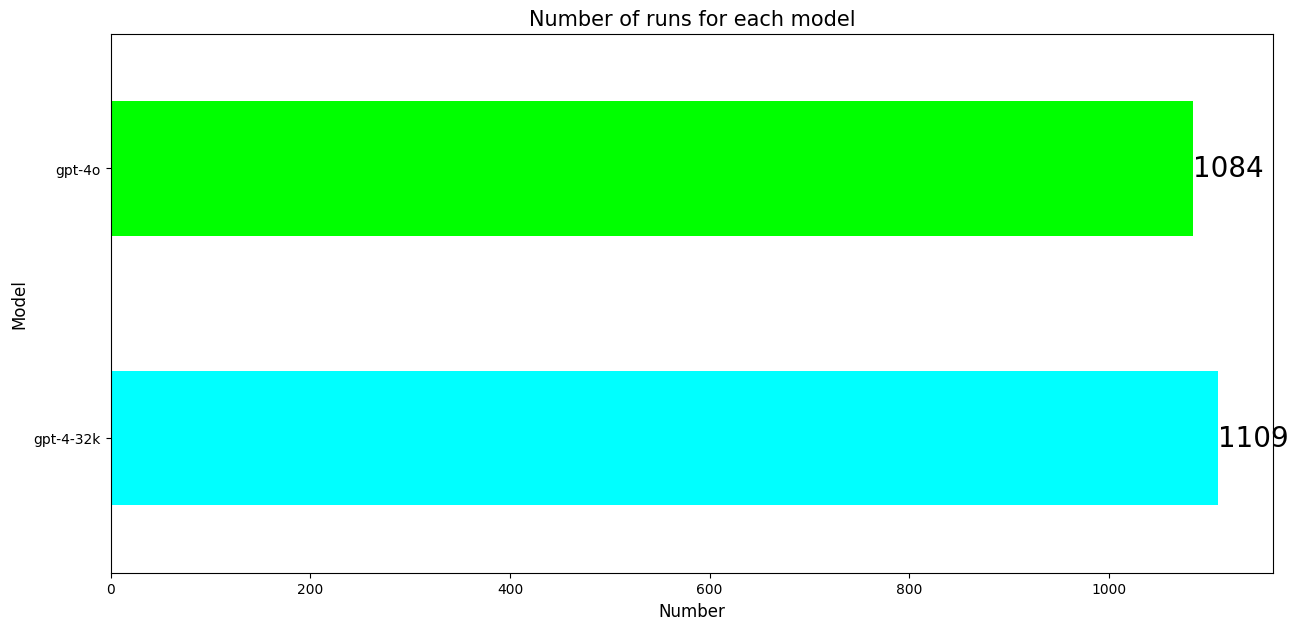

In [16]:
colors = [color1, color2]
plt.figure(figsize=(15, 7))

value_counts = df['model'].value_counts(sort=True)
ax = value_counts.plot.barh(color=colors)
plt.xlabel('Number', size=12)
plt.ylabel('Model', size=12)
plt.title('Number of runs for each model', size=15)

for index, value in enumerate(value_counts):
    ax.text(value, index, str(value), va='center', ha='left', size=20)

plt.show()

## 3. Plots

In [17]:
int_columns = ['failures', 'throttled']

float_columns = [
    'rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg',
    'e2e_95th', 'util_avg', 'util_95th'
]

cols_to_plot = int_columns + float_columns

values_to_min = [
    'failures', 'throttled', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th',
    'e2e_avg', 'e2e_95th'
]
values_to_max = ['rpm', 'tpm']
values_misc = ['util_avg', 'util_95th']

In [18]:
cm = sns.light_palette('darkblue', as_cmap=True)

In [19]:
idx = 1
for col in values_to_max:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for metric: {col.upper()} ({metrics_labels[col]})")
    styled_statistics = apply_gradient(statistics, cm)
    display(styled_statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for metric: RPM (Successful Requests Per Minute)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,8.432372,1.667601,1.900000,8.000000,9.000000,9.300000,12.000000
gpt-4o,1084.000000,12.858856,0.787333,8.600000,12.300000,13.000000,13.000000,17.100000



 ------------------------------------------------------------------------------------------

2 Statistics for metric: TPM (Tokens Per Minute)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,8453.468891,1672.681223,1881.000000,8024.000000,9027.000000,9338.000000,12048.000000
gpt-4o,1084.000000,12906.031365,792.547992,8605.000000,12339.250000,13039.000000,13052.000000,17212.000000



 ------------------------------------------------------------------------------------------


In [20]:
idx = 1

for col in values_to_min:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for {col.upper()} ({metrics_labels[col]})")
    styled_statistics = statistics.style.apply(
        lambda x:
        ['background-color: lightblue' if v == x.min() else '' for v in x],
        axis=0)
    display(styled_statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for FAILURES (Total number of failed requests out of requests)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt-4o,1084.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



 ------------------------------------------------------------------------------------------

2 Statistics for THROTTLED (Total number of throttled requests out of requests)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gpt-4o,1084.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



 ------------------------------------------------------------------------------------------

3 Statistics for TTFT_AVG (Average time in seconds from the beginning of the request until the first token was received)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.460628,0.086621,0.374000,0.417000,0.437000,0.485000,1.197000
gpt-4o,1084.000000,0.156958,0.032416,0.119000,0.135000,0.143000,0.172000,0.274000



 ------------------------------------------------------------------------------------------

4 Statistics for TTFT_95TH (95th percentile of time in seconds from the beginning of the request until the first token was received)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.646833,0.274966,0.000000,0.497000,0.590000,0.726000,1.844000
gpt-4o,1084.000000,0.237077,0.107182,0.000000,0.178000,0.207000,0.254000,0.701000



 ------------------------------------------------------------------------------------------

5 Statistics for TBT_AVG (Average time in seconds between two consecutive generated tokens)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.047316,0.005465,0.034000,0.043000,0.048000,0.052000,0.060000
gpt-4o,1084.000000,0.012526,0.000769,0.010000,0.012000,0.012000,0.013000,0.016000



 ------------------------------------------------------------------------------------------

6 Statistics for TBT_95TH (95th percentile of time in seconds between two consecutive generated tokens)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,0.059558,0.014945,0.000000,0.051000,0.060000,0.070000,0.087000
gpt-4o,1084.000000,0.015062,0.001813,0.000000,0.014000,0.015000,0.016000,0.019000



 ------------------------------------------------------------------------------------------

7 Statistics for E2E_AVG (Average end to end request time)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,24.236472,2.479199,17.474000,22.346000,24.417000,26.191000,30.383000
gpt-4o,1084.000000,6.439298,0.274322,5.458000,6.290000,6.392000,6.557000,8.202000



 ------------------------------------------------------------------------------------------

8 Statistics for E2E_95TH (95th percentile of end to end request time)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.000000,31.633380,7.612826,0.000000,25.959000,32.746000,36.911000,43.571000
gpt-4o,1084.000000,7.739101,0.782202,0.000000,7.186000,7.660500,8.211000,9.164000



 ------------------------------------------------------------------------------------------


In [21]:
# Only available for PTU deployed models

idx = 1

for col in values_misc:
    statistics = df.groupby('model')[col].describe()
    print(f"\n{idx} Statistics for metric: {col.upper()} ({metrics_labels[col]})")
    display(statistics)
    print("\n", "-" * 90)
    idx += 1


1 Statistics for metric: UTIL_AVG (Average deployment utilization percentage as reported by the service)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gpt-4o,1084.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



 ------------------------------------------------------------------------------------------

2 Statistics for metric: UTIL_95TH (95th percentile of deployment utilization percentage as reported by the service)


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
gpt-4-32k,1109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gpt-4o,1084.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



 ------------------------------------------------------------------------------------------


1


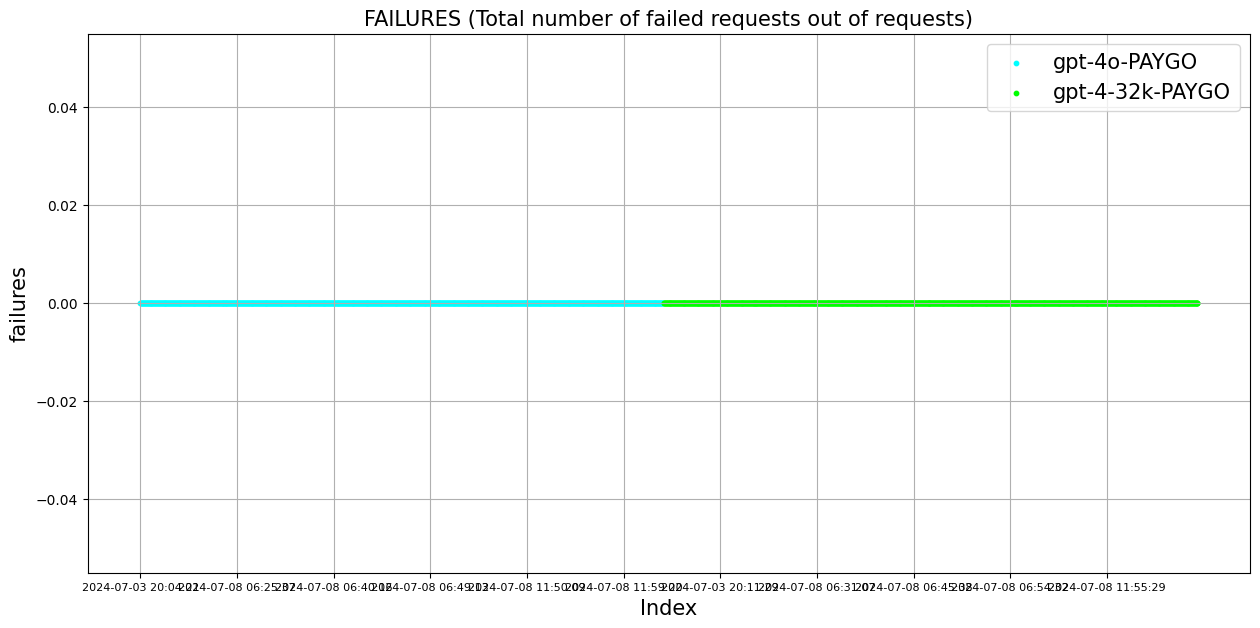

2


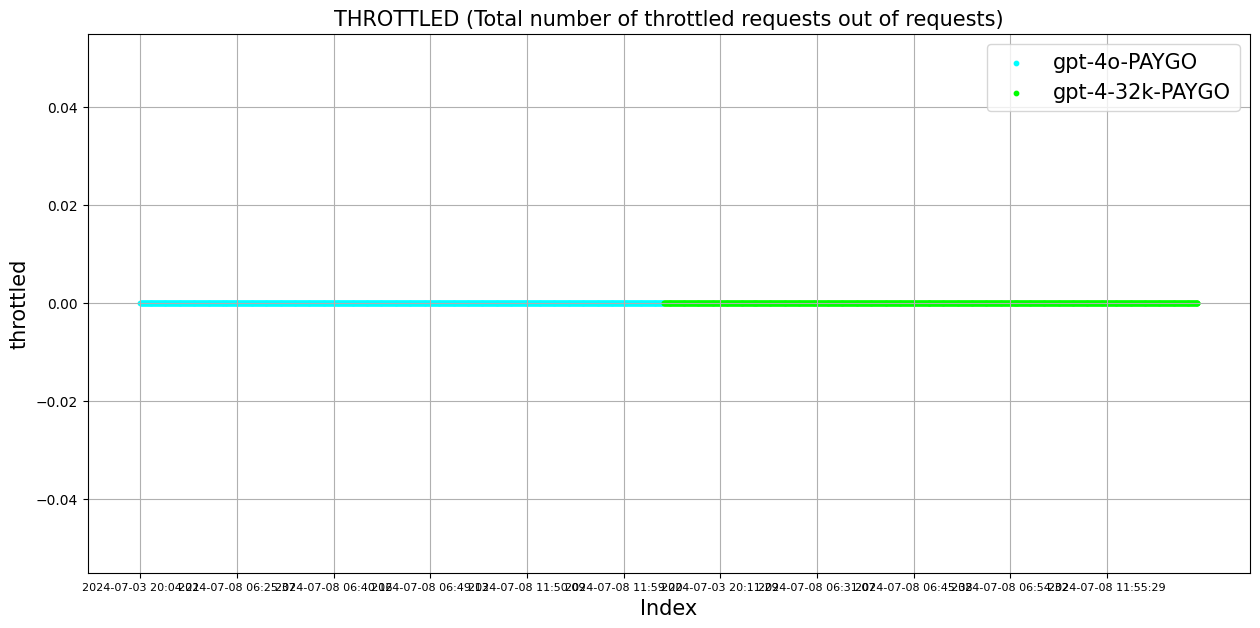

3


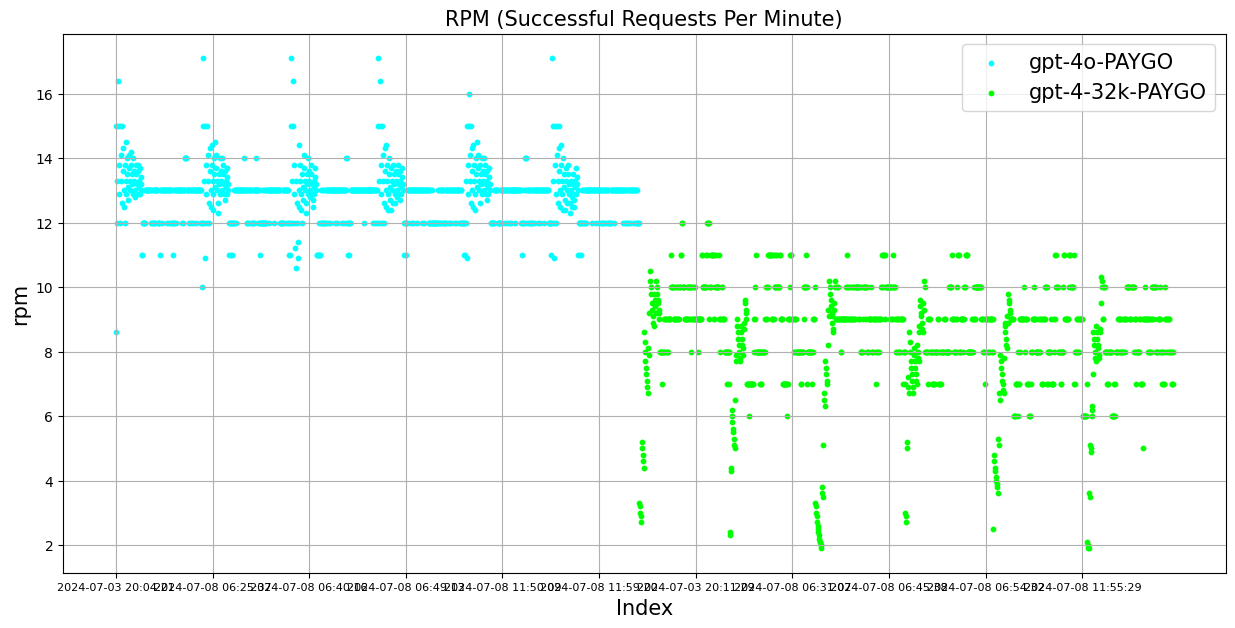

4


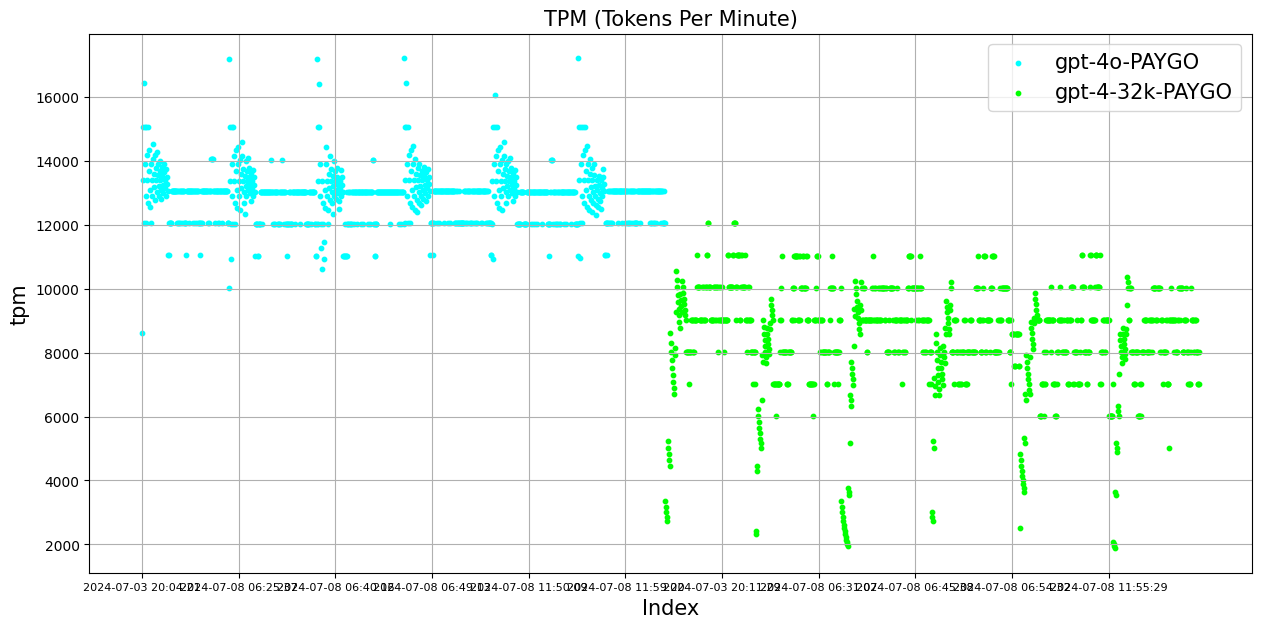

5


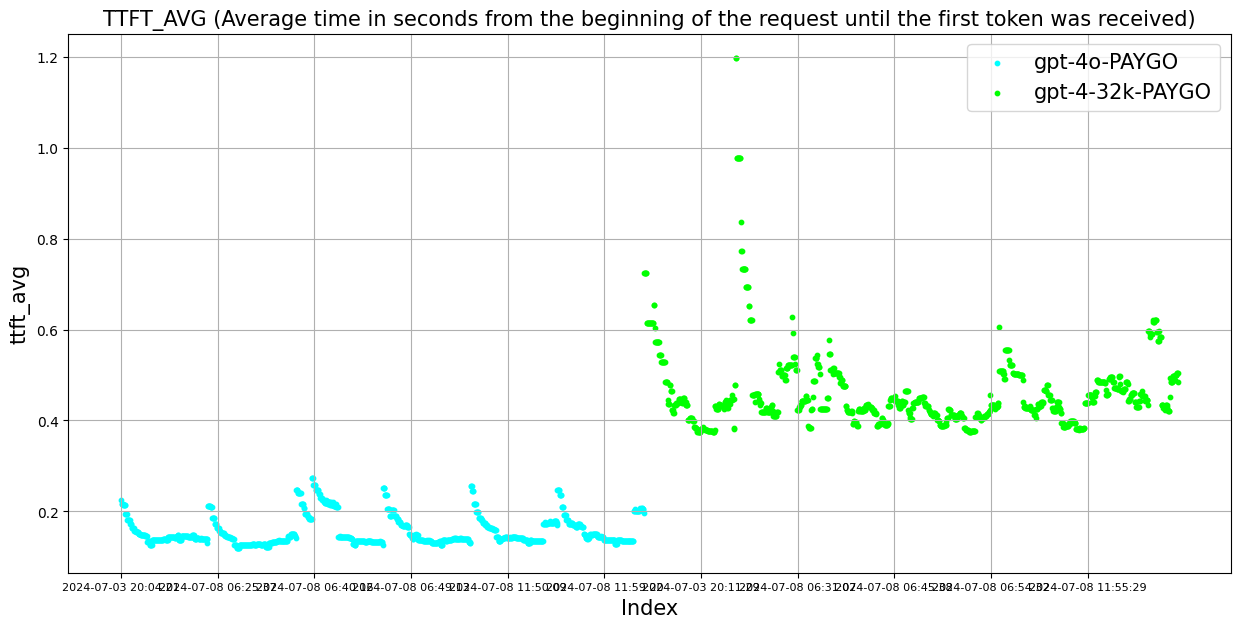

6


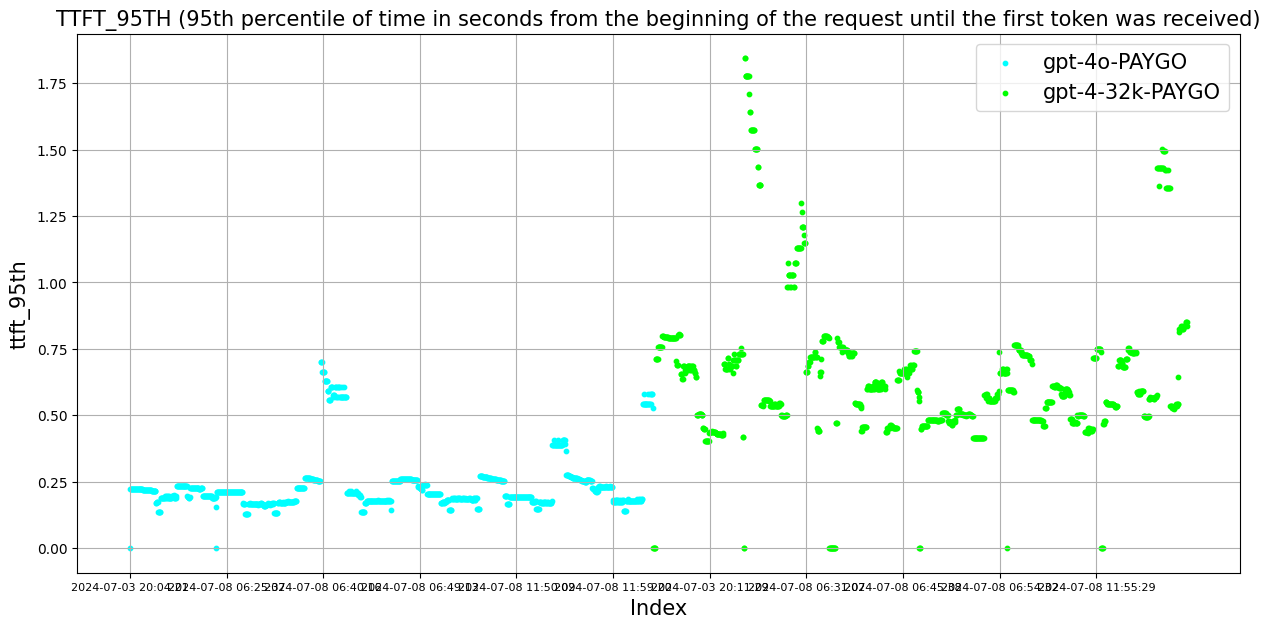

7


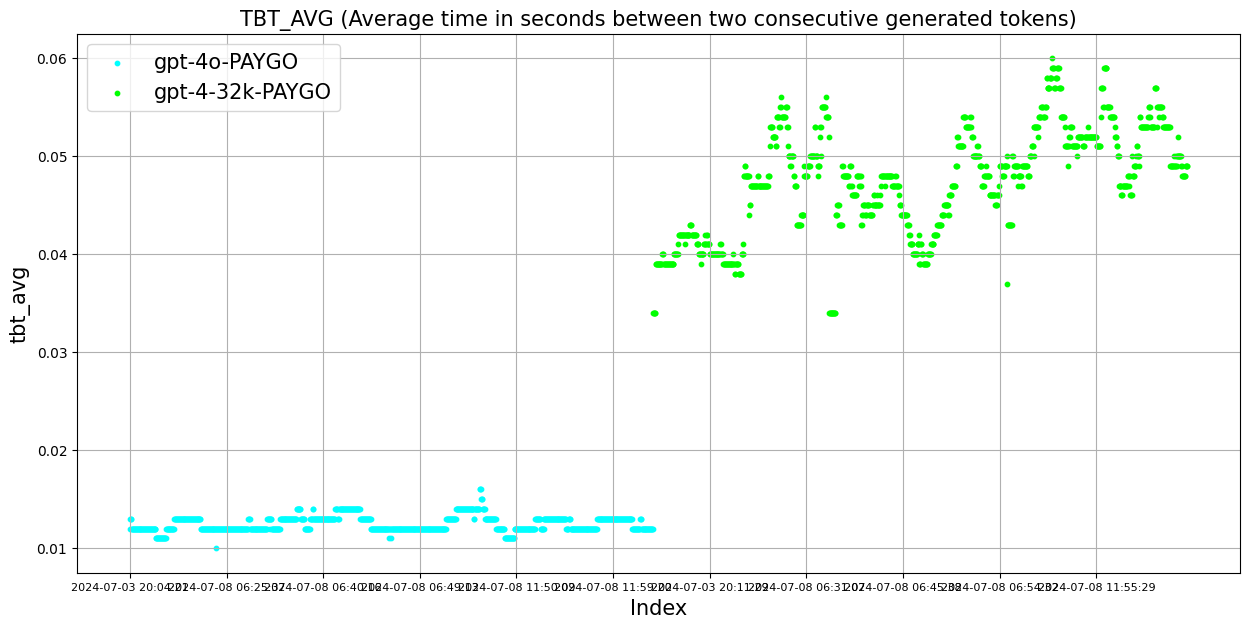

8


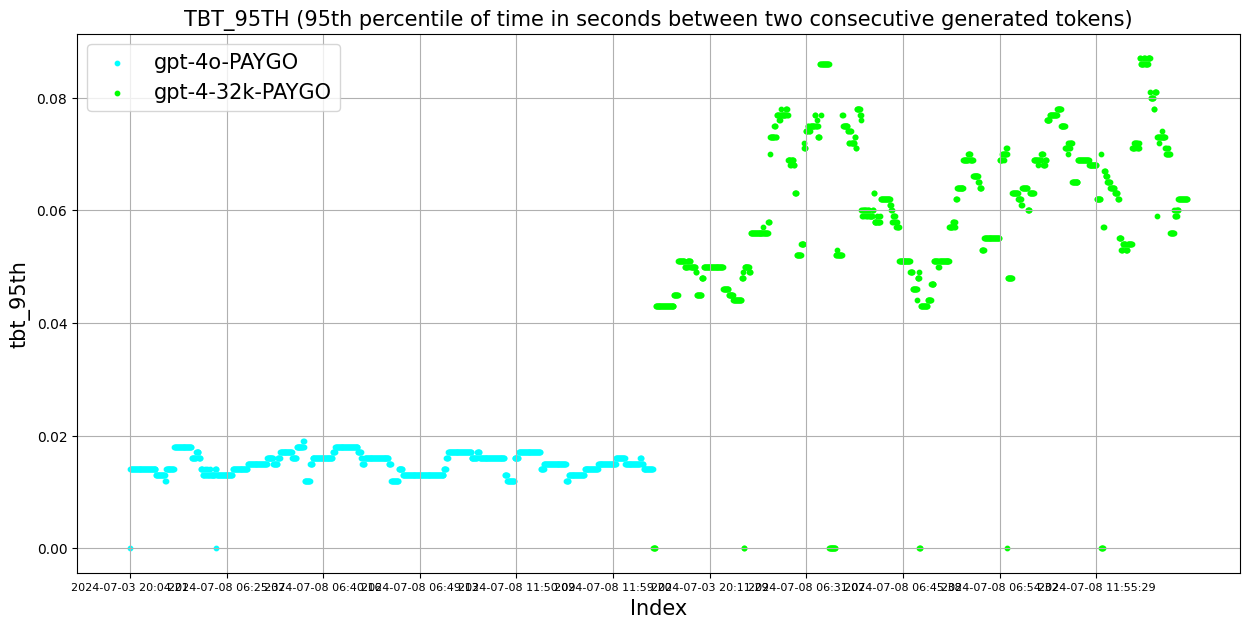

9


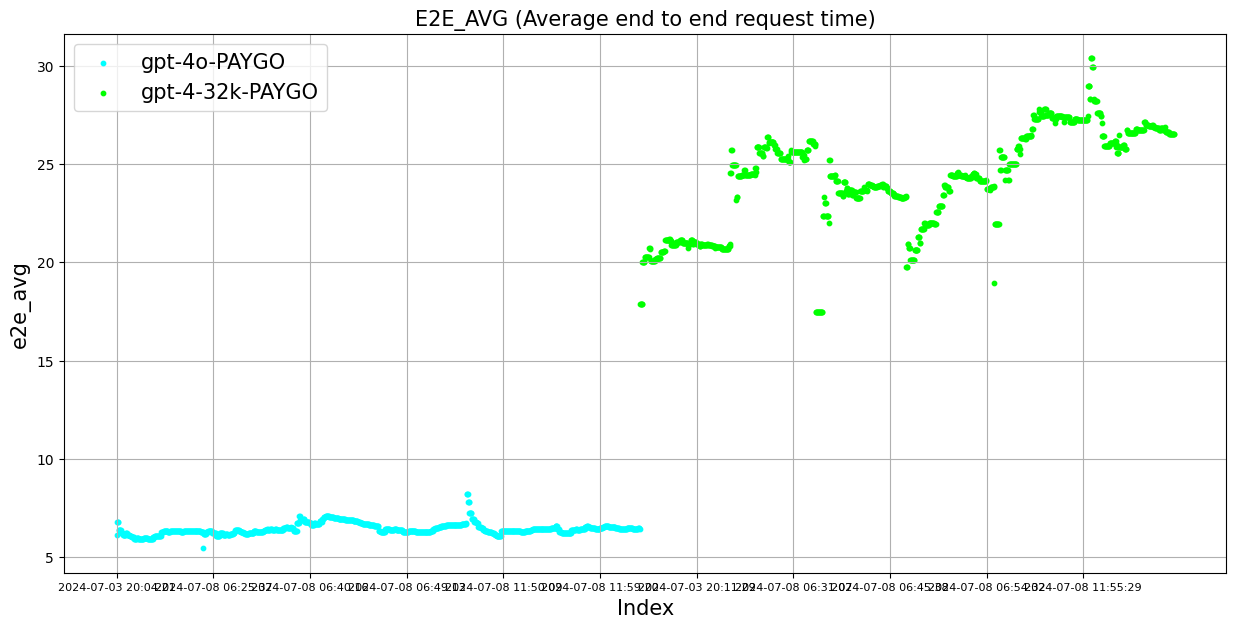

10


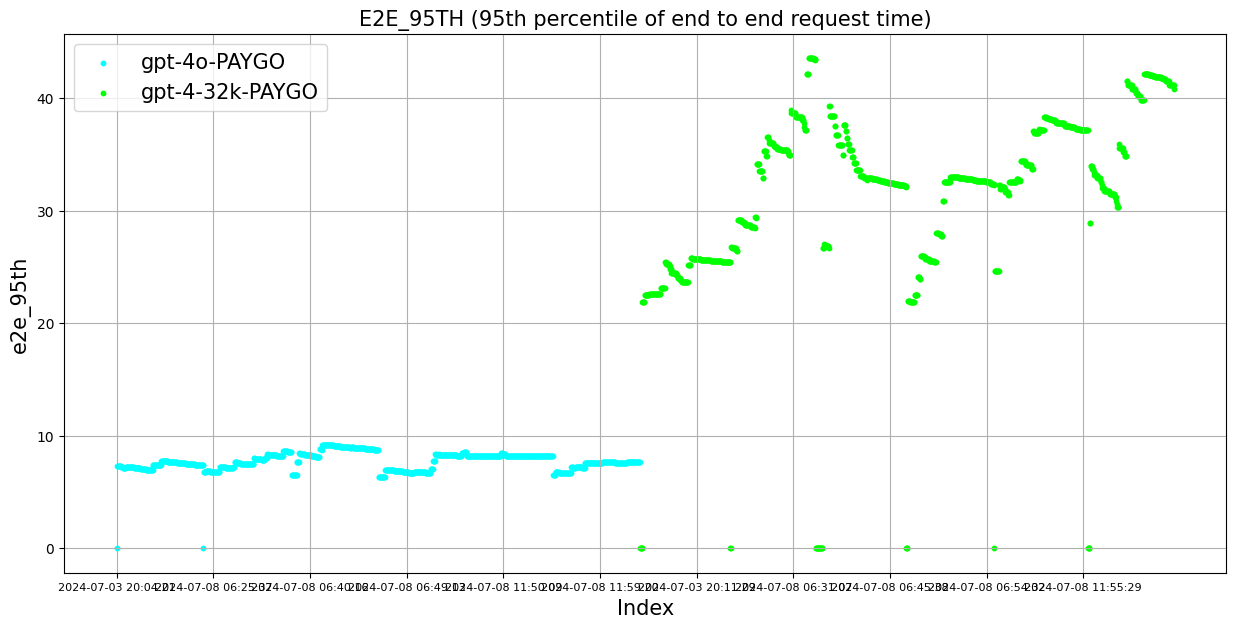

11


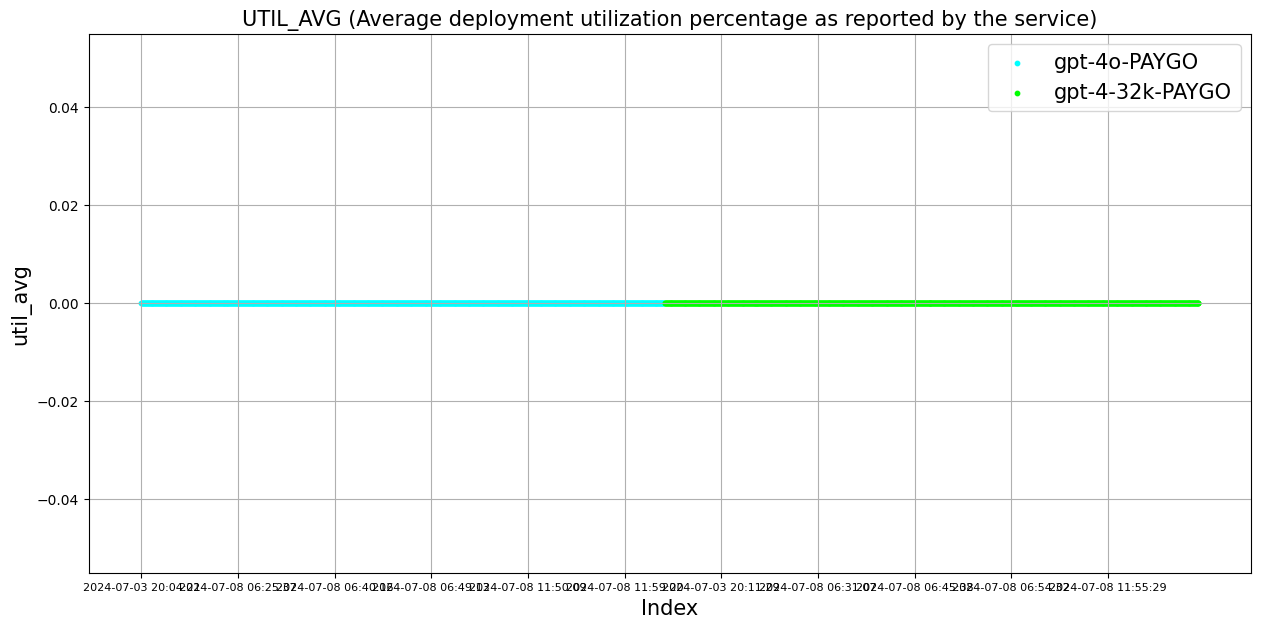

12


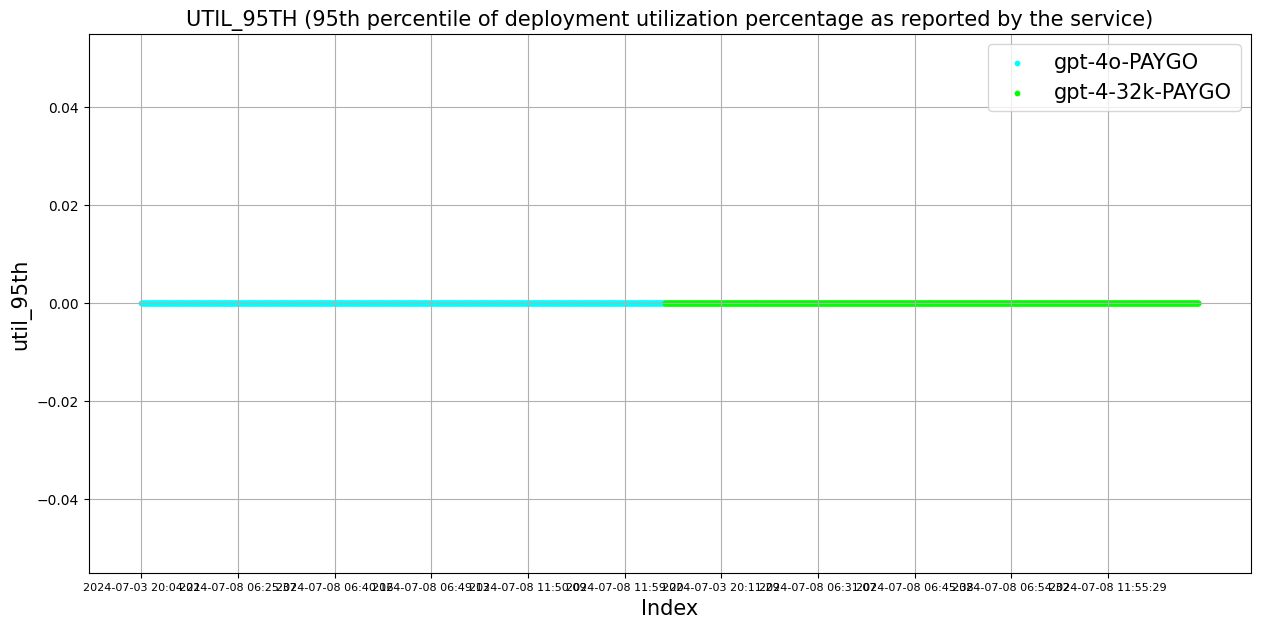

In [22]:
marker_size = 10
idx = 1
color_map = {'gpt-4o': color1, 'gpt-4-32k': color2}
legend_labels = {
    'gpt-4o': 'gpt-4o-PAYGO',
    'gpt-4-32k': 'gpt-4-32k-PAYGO'
}

for col in cols_to_plot:
    plt.figure(figsize=(15, 7))
    print(idx)
    
    for value in df['model'].unique():
        subset = df[df['model'] == value]
        plt.scatter(subset.index,
                    subset[col],
                    label=legend_labels[value],
                    color=color_map[value],
                    s=marker_size)
    
    plt.xticks(np.arange(0, len(df), step=200), size=8)
    plt.xlabel('Index', fontsize=15)
    plt.ylabel(col, fontsize=15)
    plt.title(f'{col.upper()} ({metrics_labels[col]})', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    output = os.path.join(REPORT_DIR, f'plot_{col}_{dt}.png')
    plt.savefig(output, format='jpg', dpi=300)
    plt.show()
    idx += 1

1


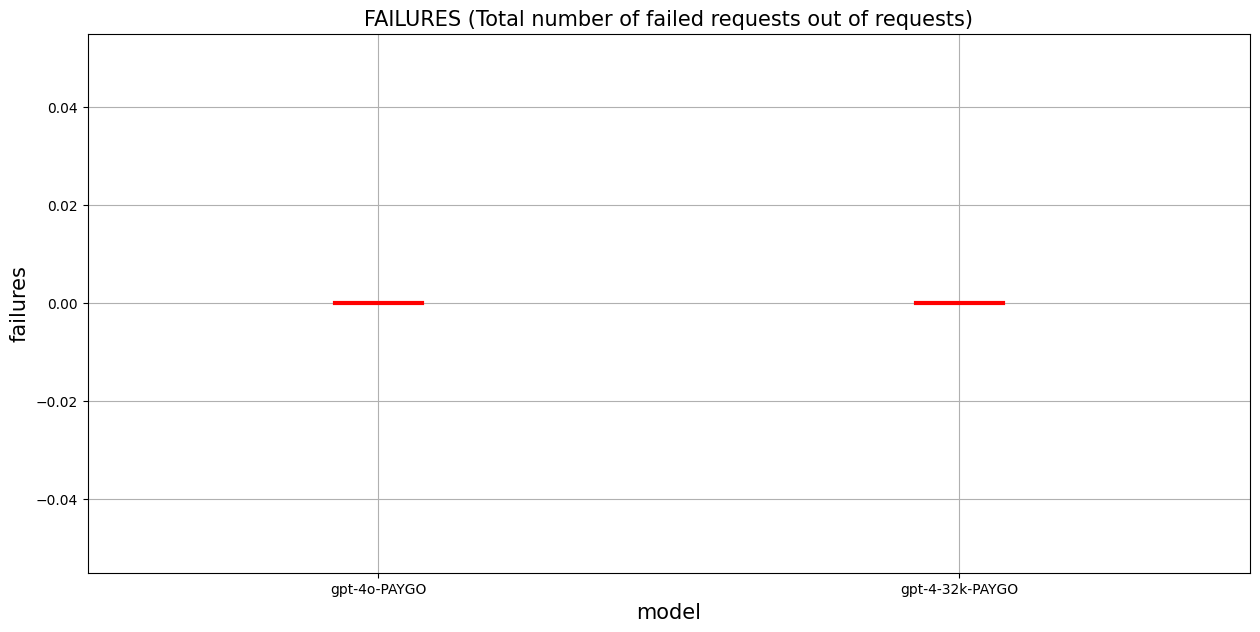

2


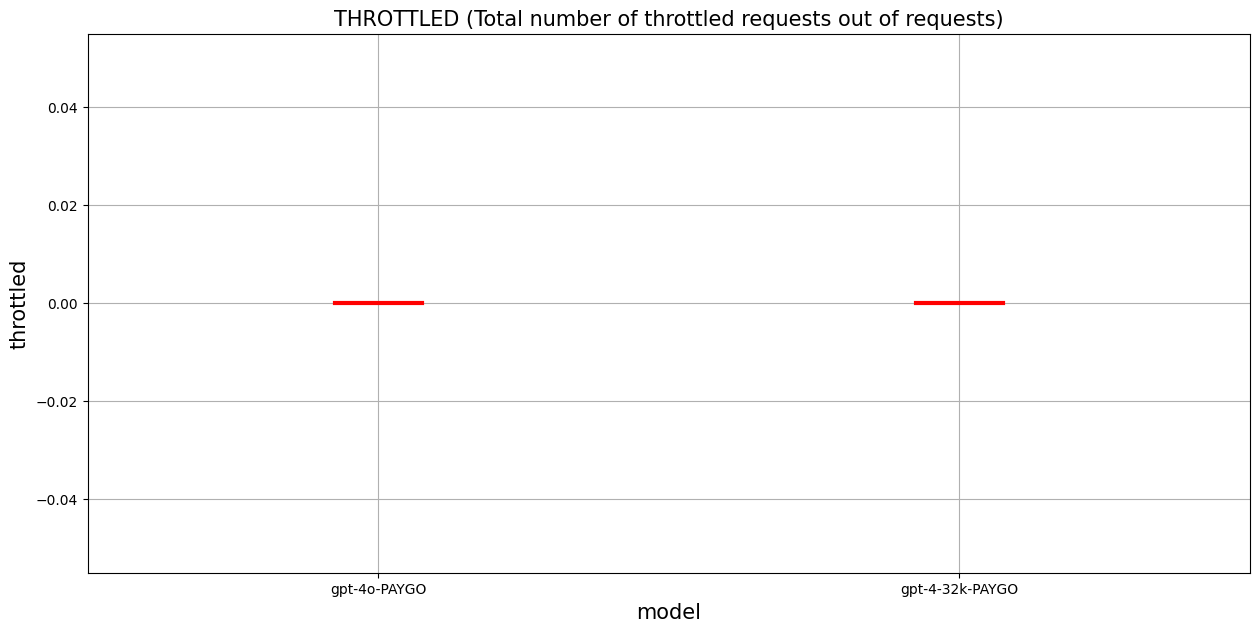

3


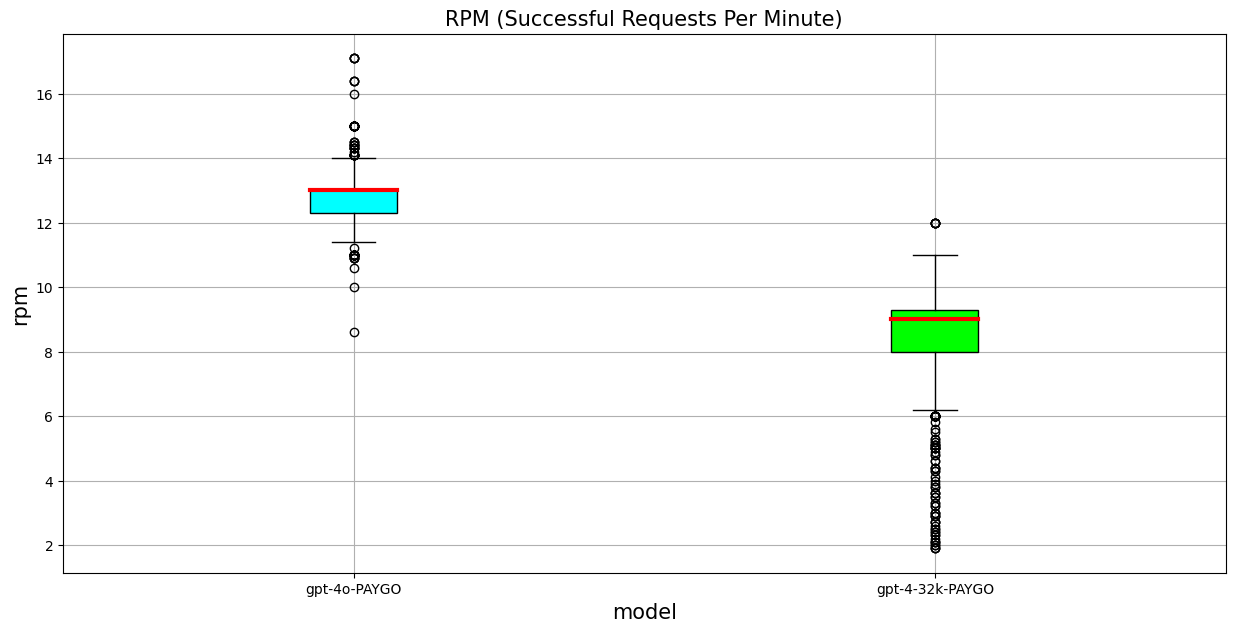

4


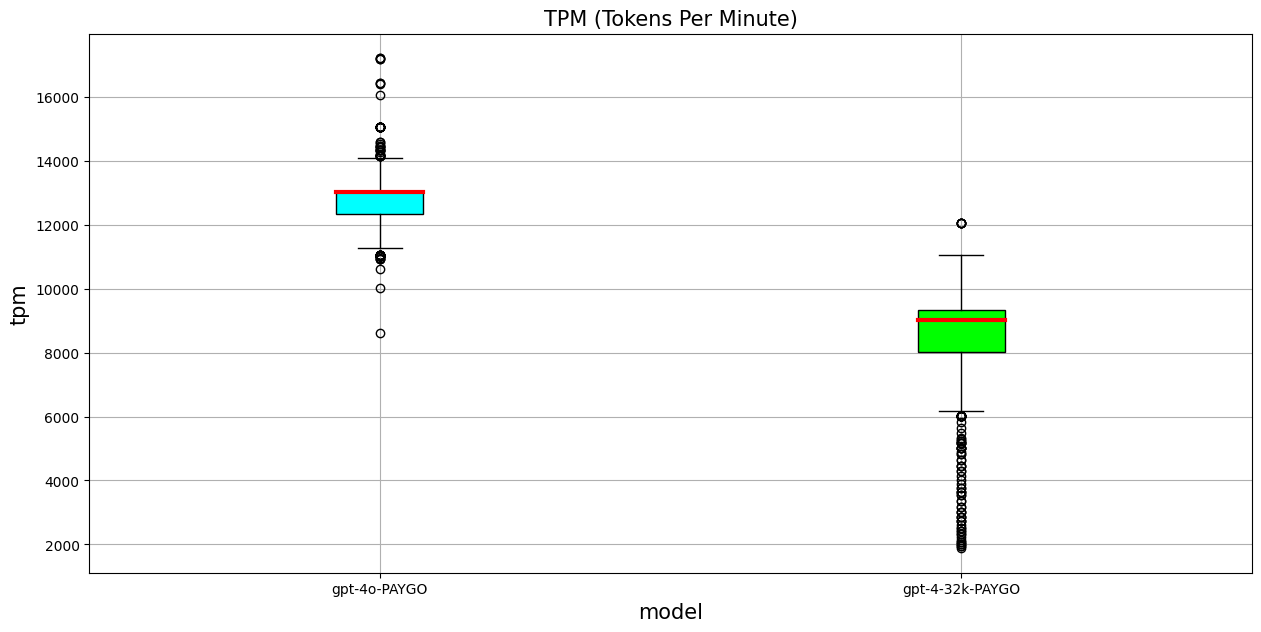

5


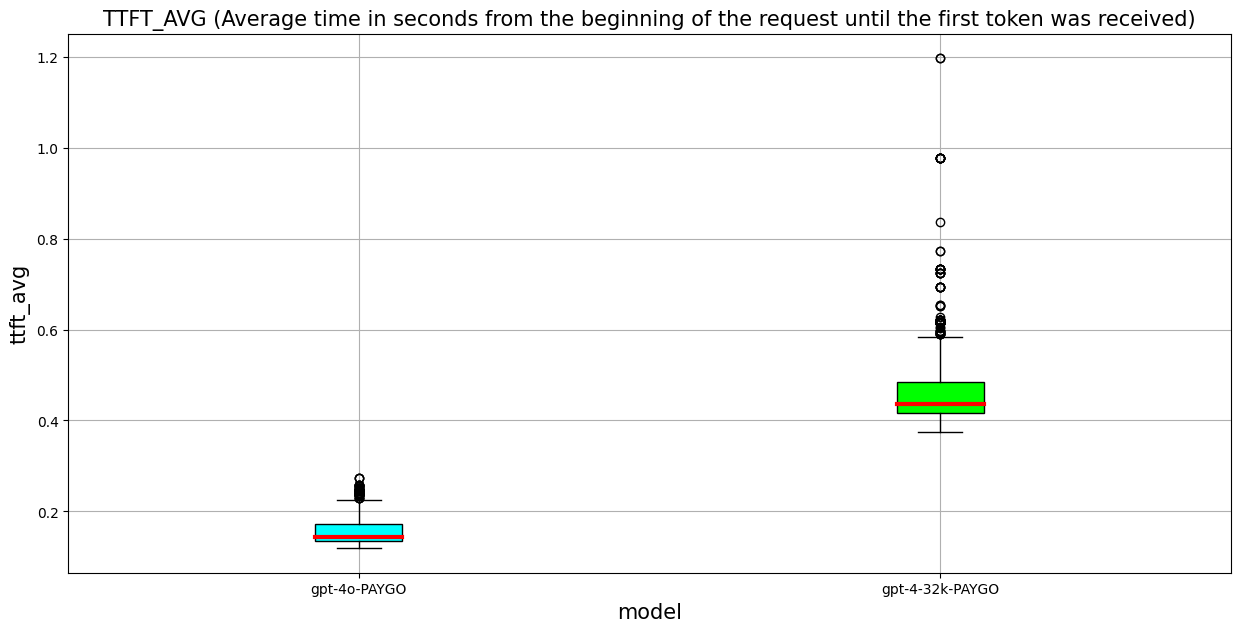

6


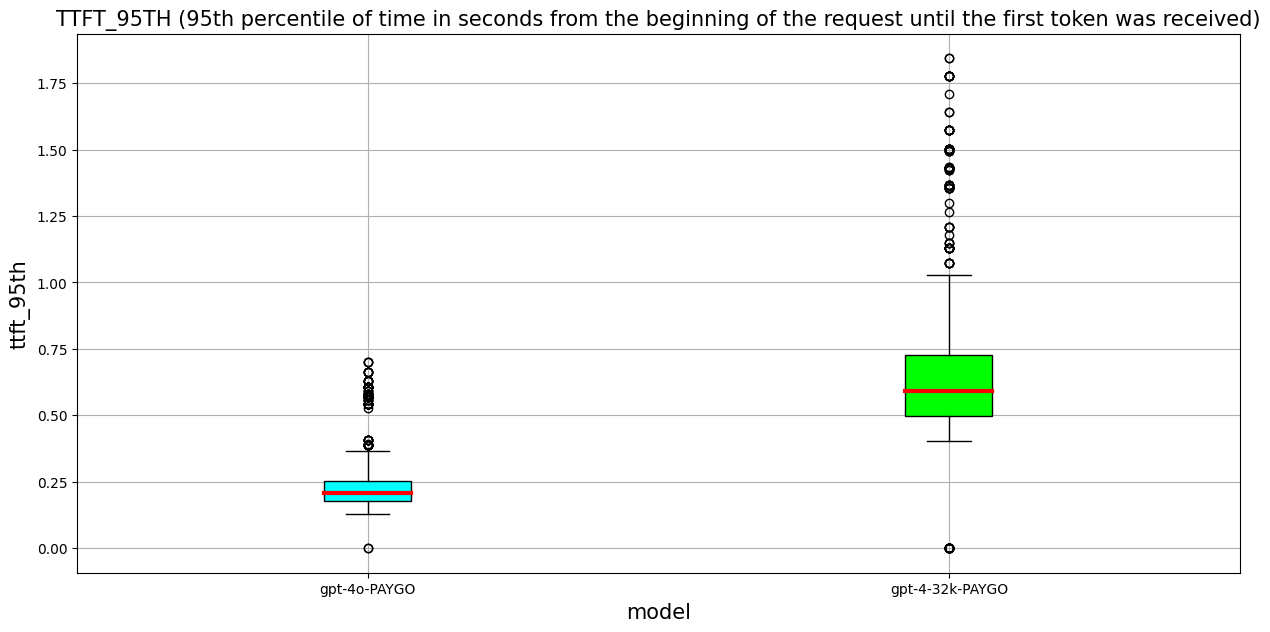

7


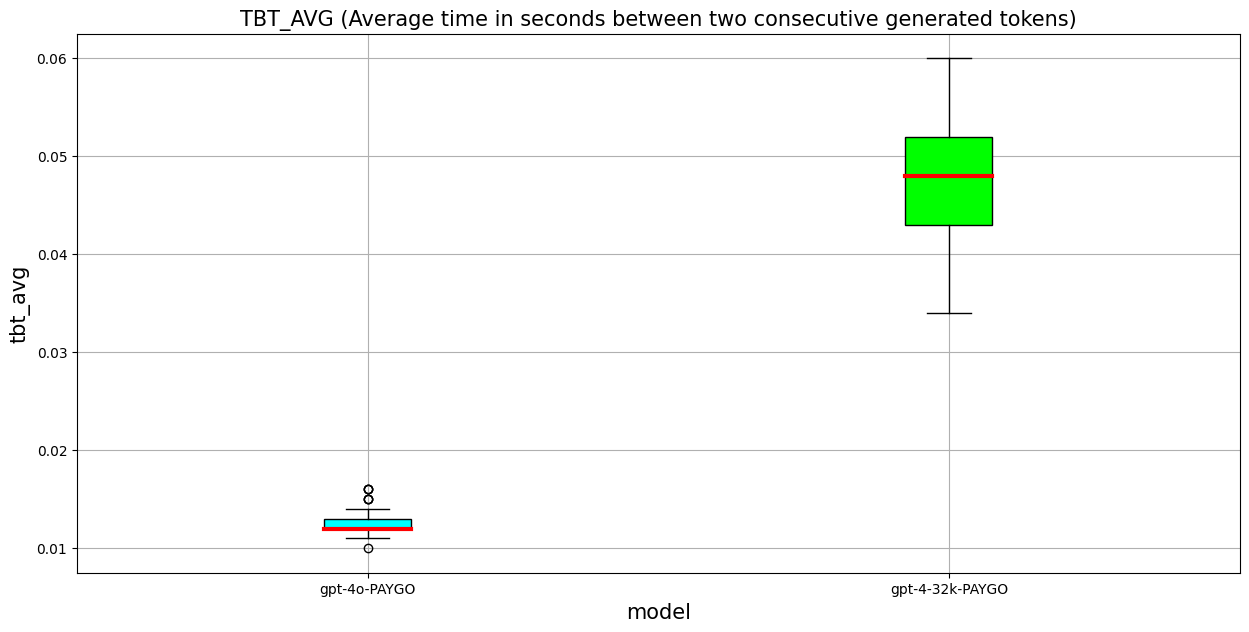

8


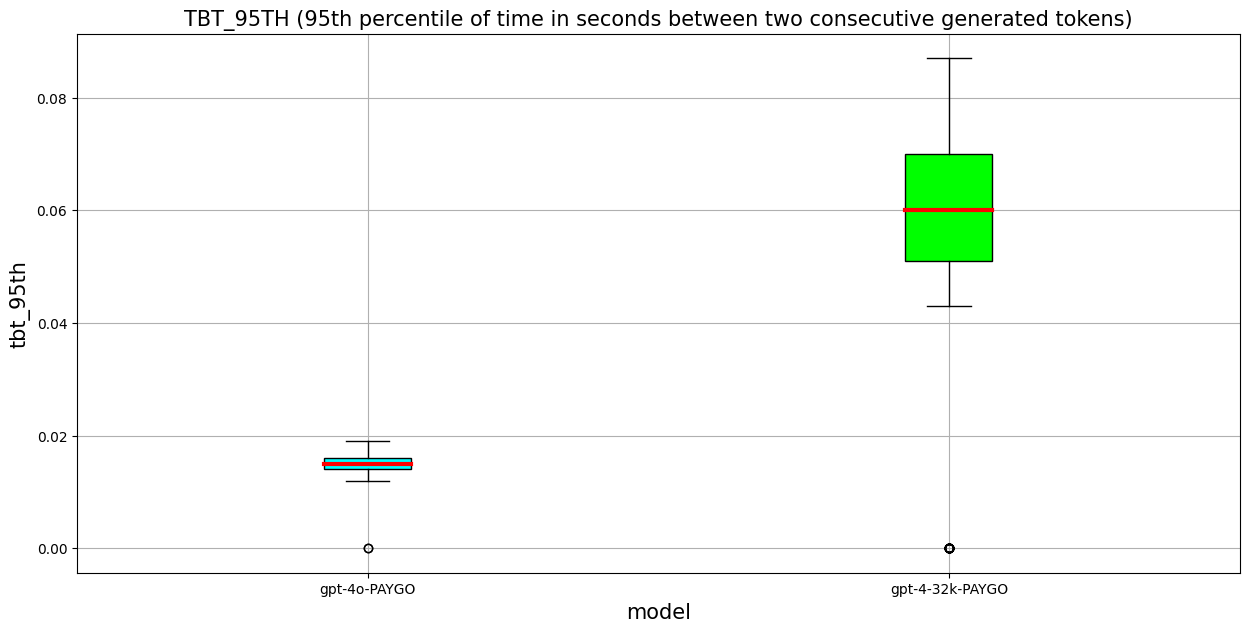

9


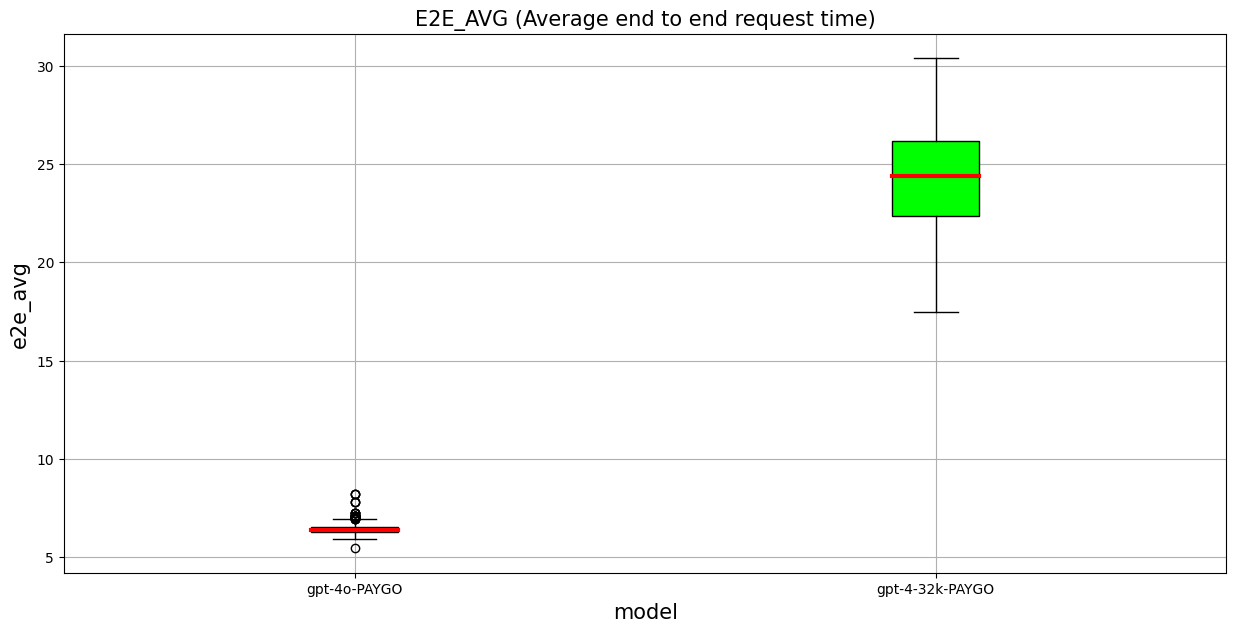

10


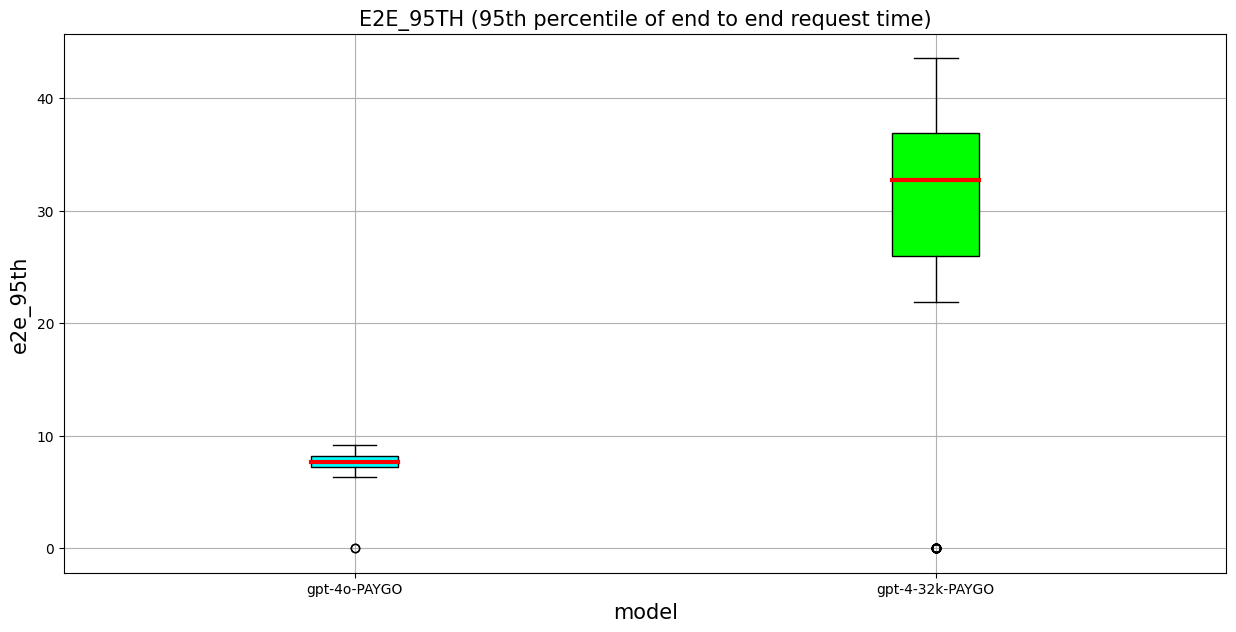

11


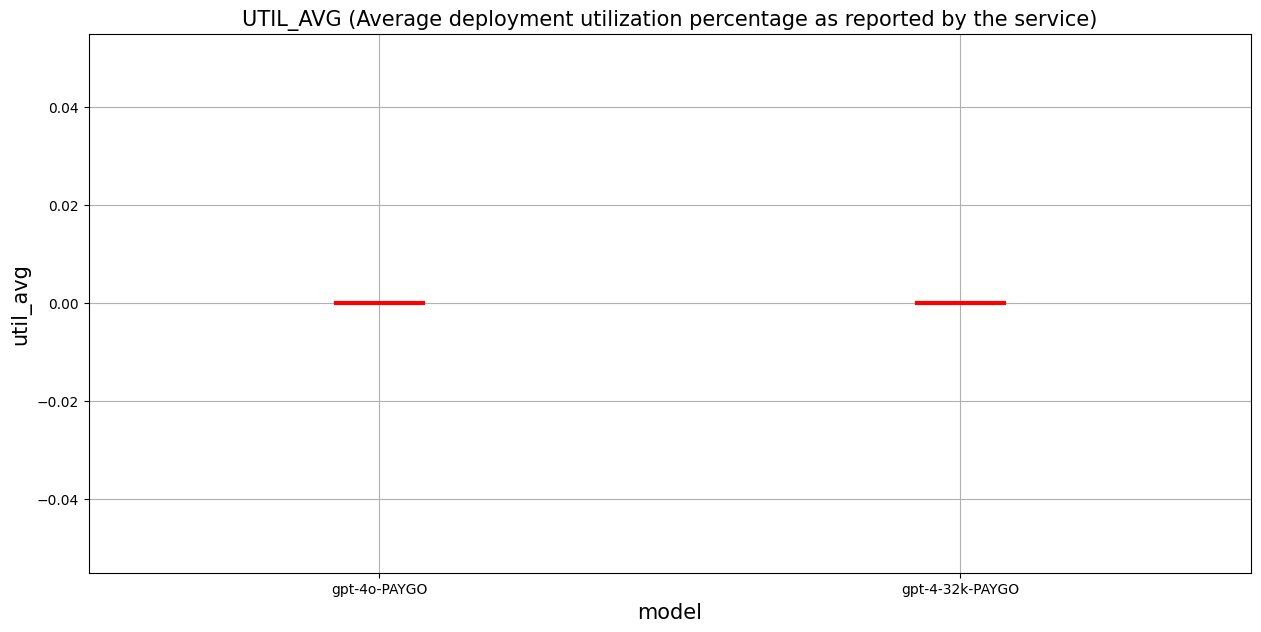

12


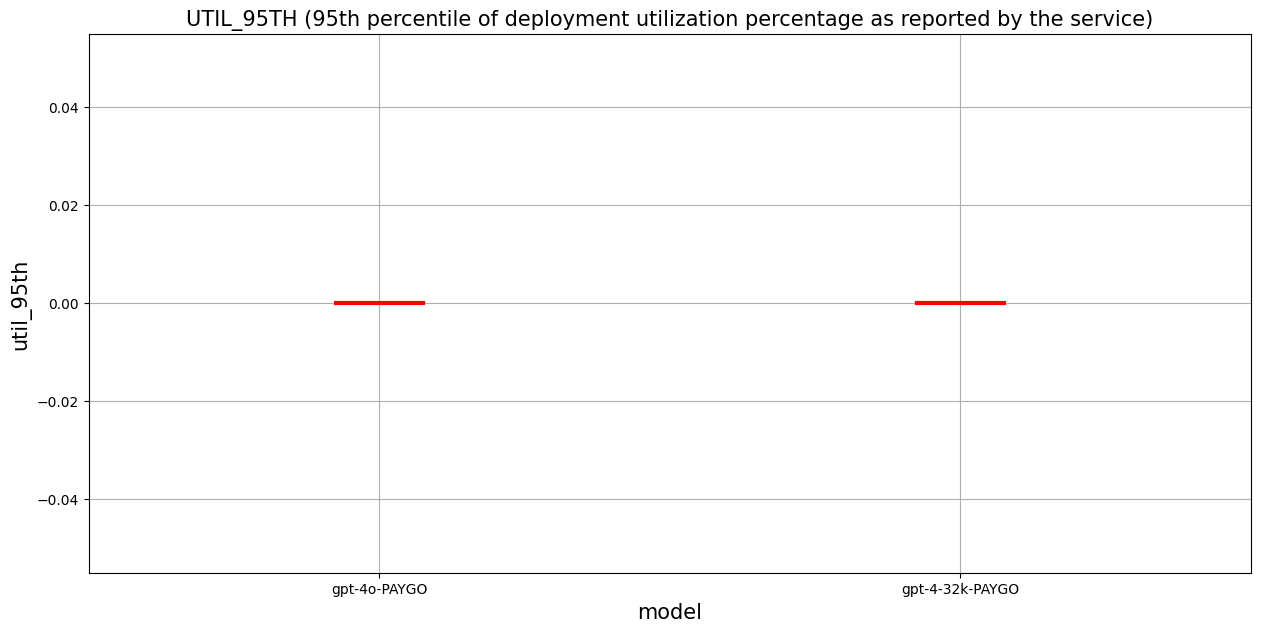

In [23]:
idx = 1
colors = [color1, color2]

for col in cols_to_plot:
    plt.figure(figsize=(15, 7))
    print(idx)
    data_paygo = df[df['model'] == 'gpt-4o'][col]
    data_ptu =   df[df['model'] == 'gpt-4-32k'][col]
    bp = plt.boxplot([data_paygo, data_ptu],
                     labels=['gpt-4o-PAYGO', 'gpt-4-32k-PAYGO'],
                     patch_artist=True)
    
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
    for median in bp['medians']:
        median.set(color='red', linewidth=3)
    
    plt.title(f'{col.upper()} ({metrics_labels[col]})', fontsize=15)
    plt.xlabel('model', fontsize=15)
    plt.ylabel(col, fontsize=15)
    plt.grid(True)
    plt.savefig(os.path.join(REPORT_DIR, f'boxplot_{col}_{dt}.png'))
    plt.show()
    idx += 1

1


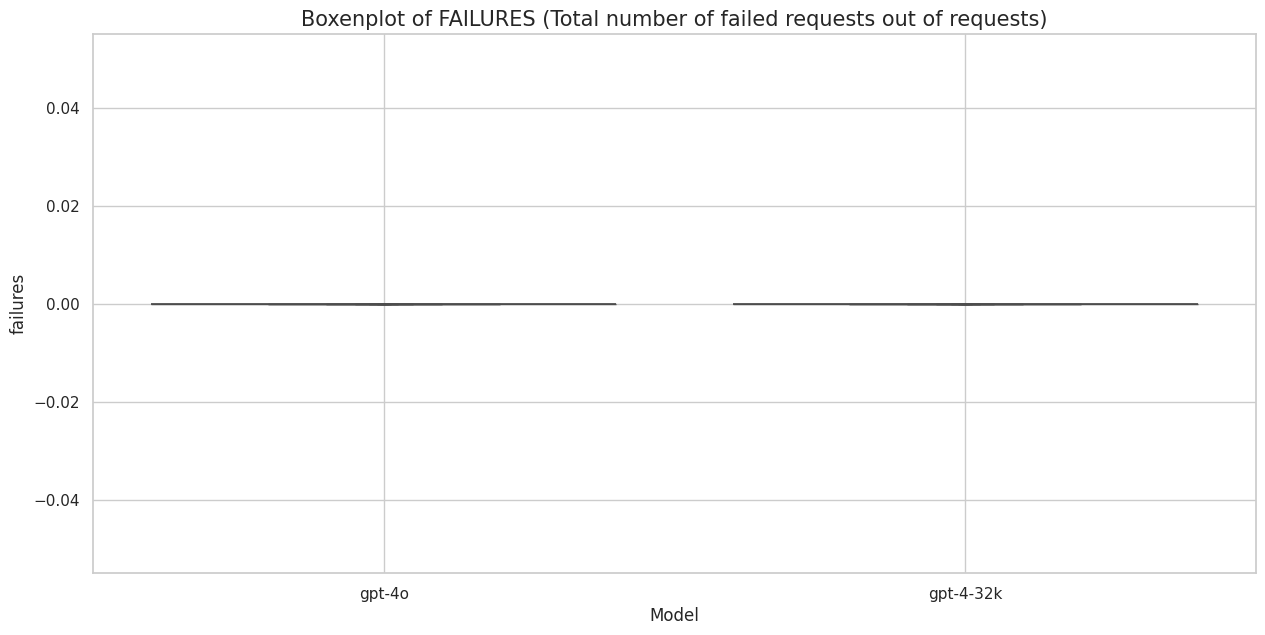

2


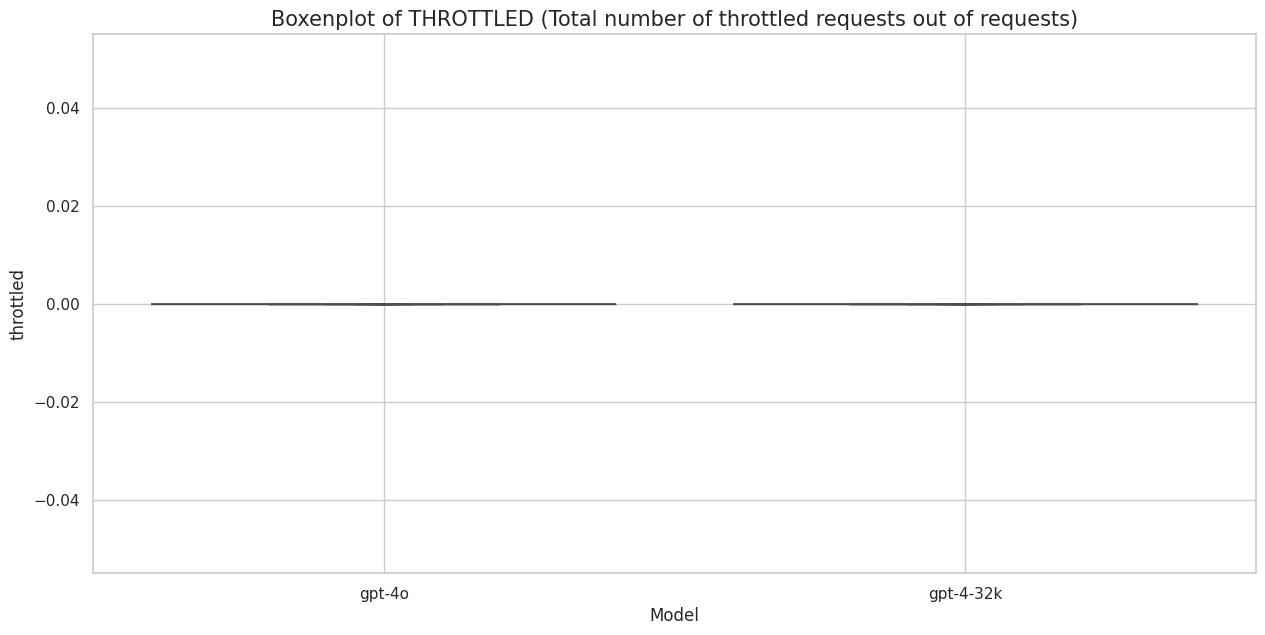

3


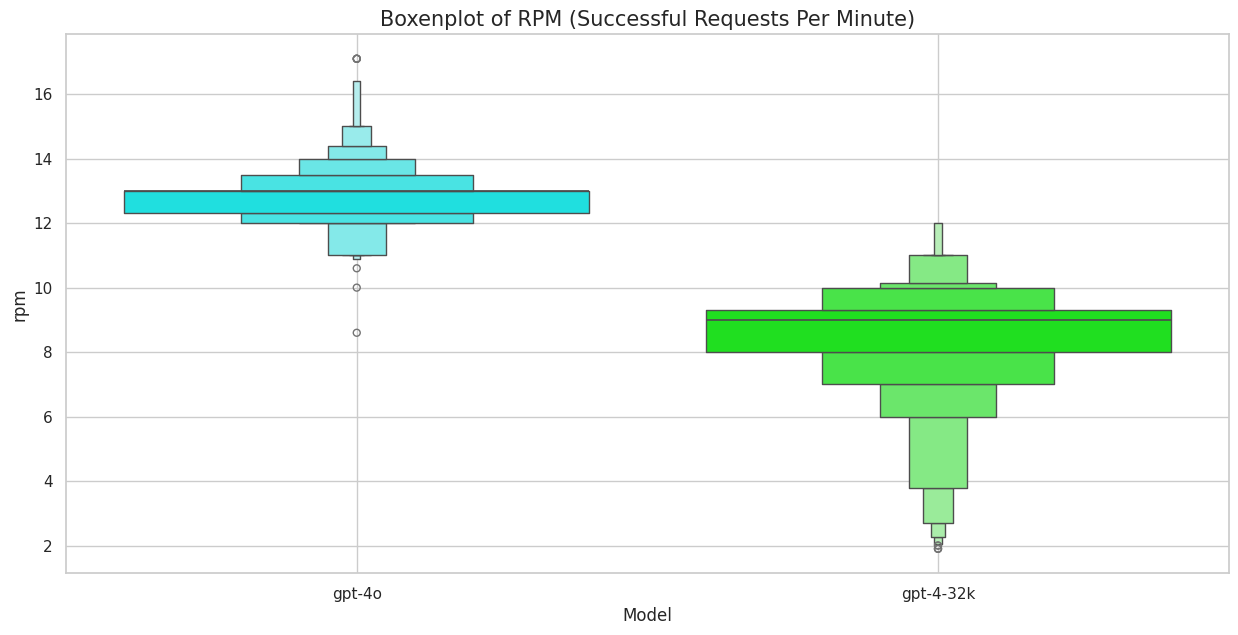

4


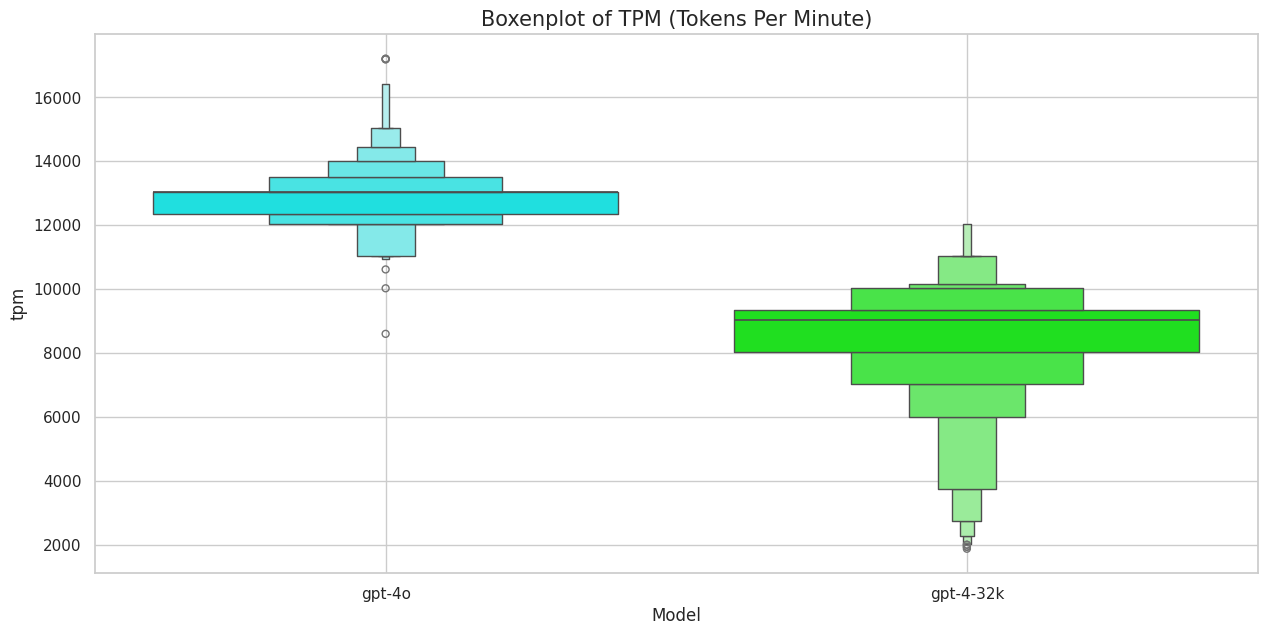

5


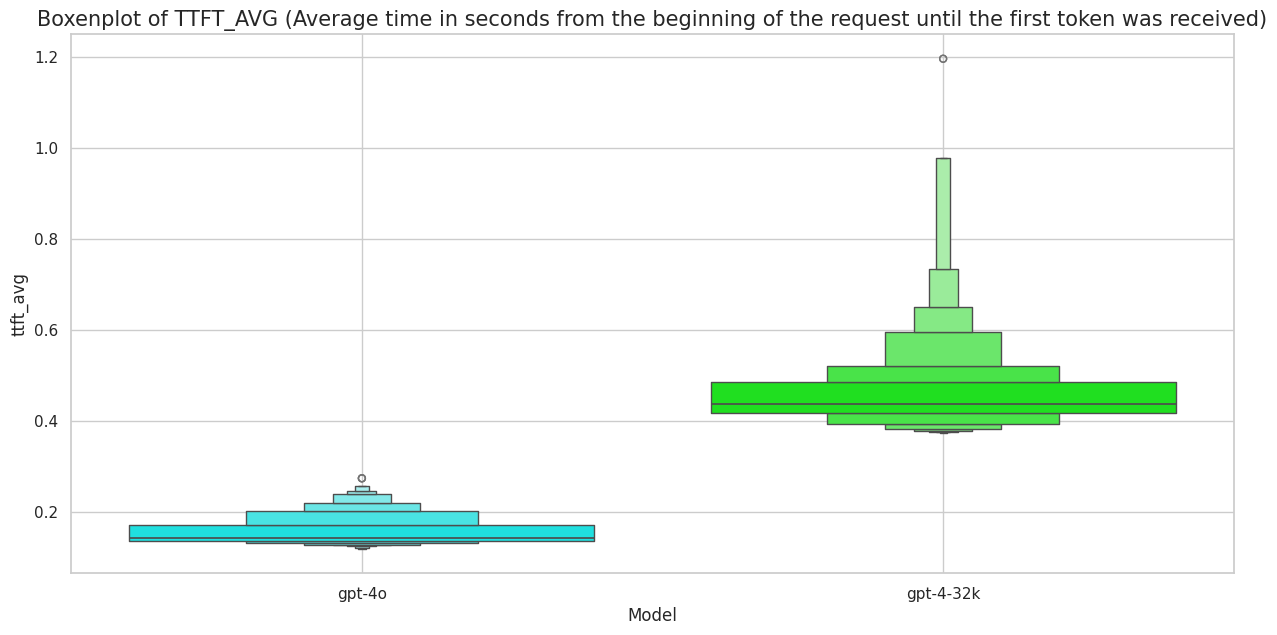

6


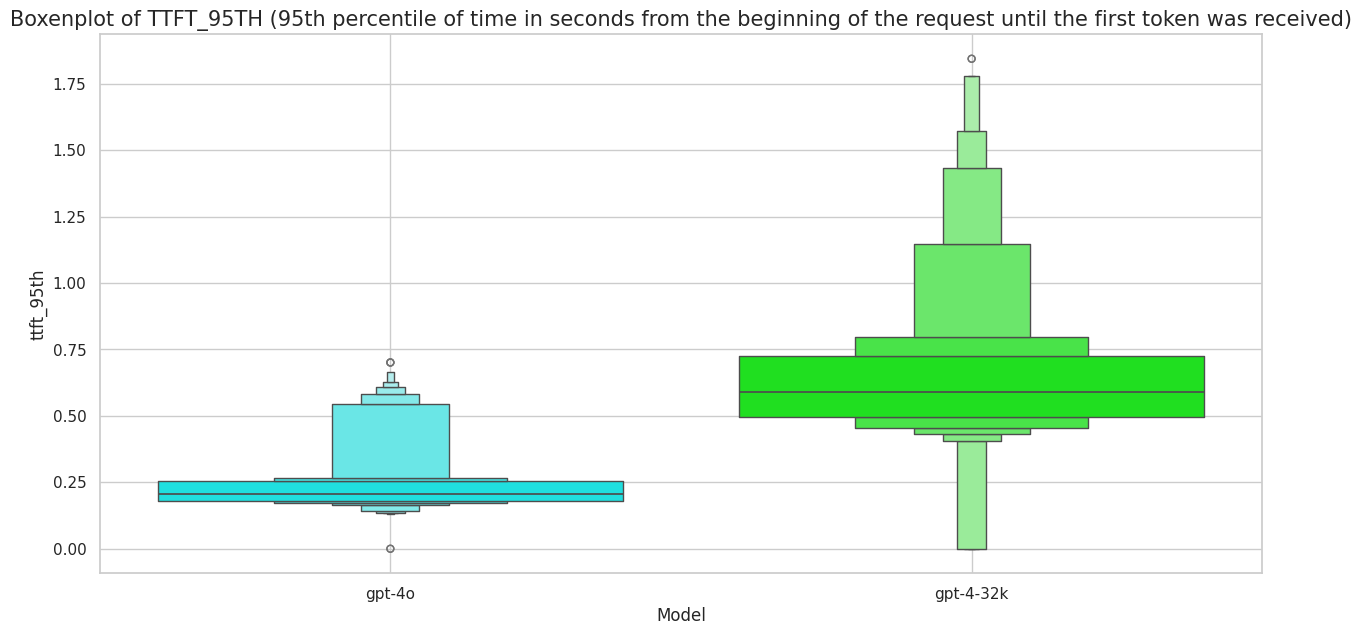

7


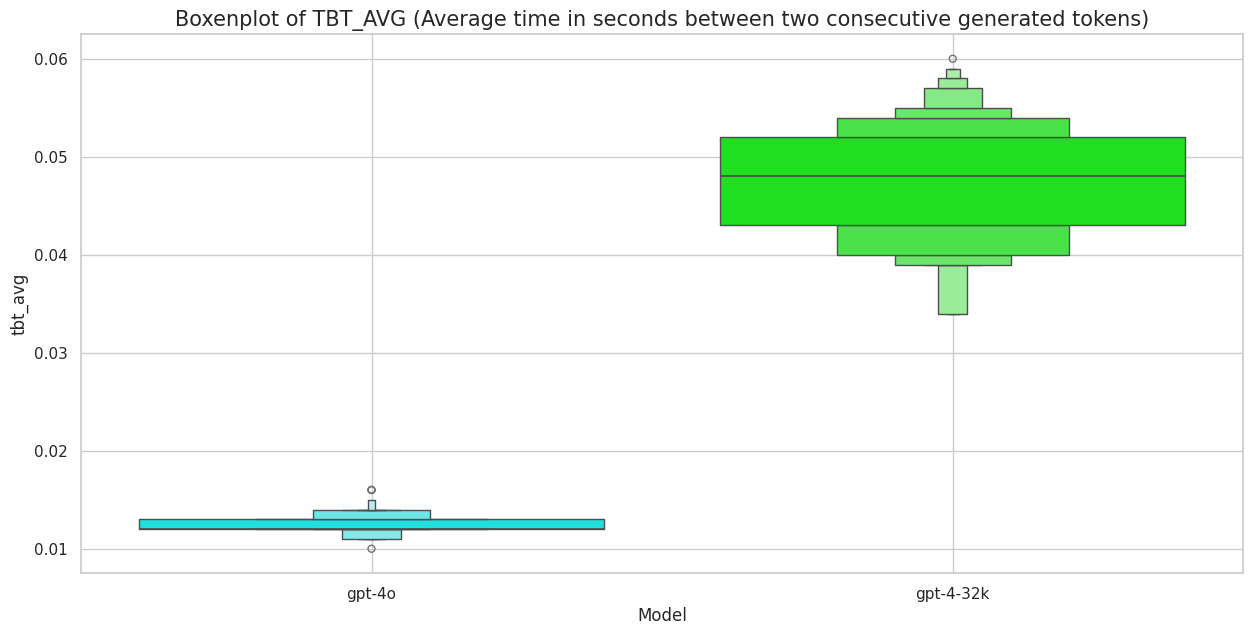

8


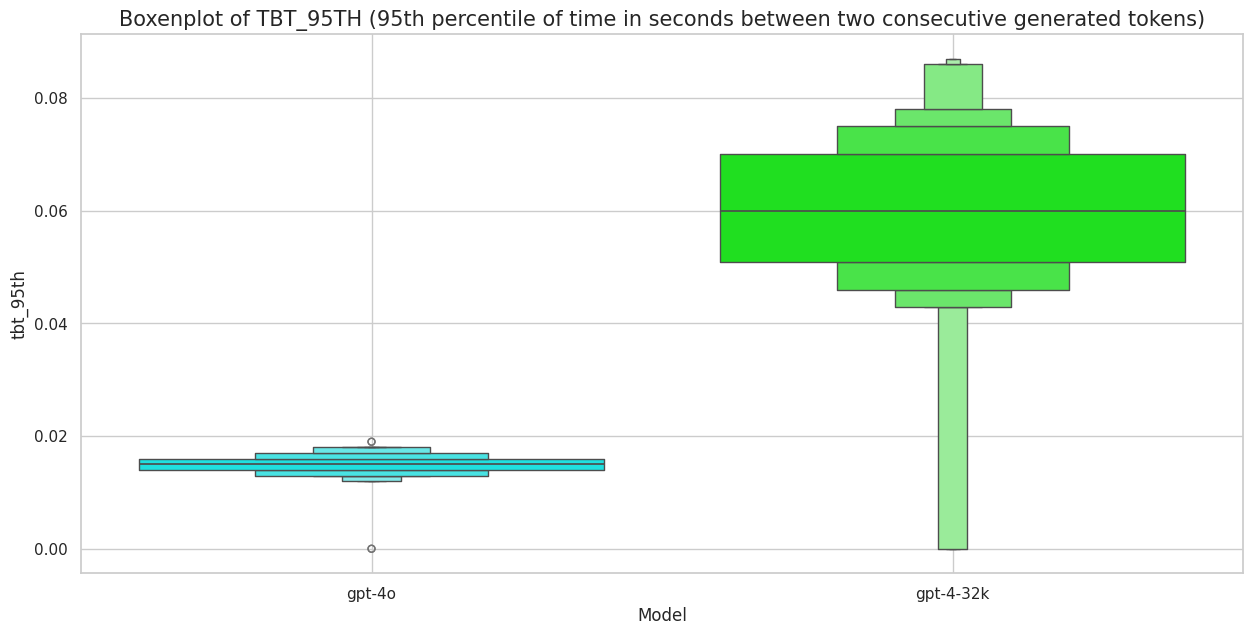

9


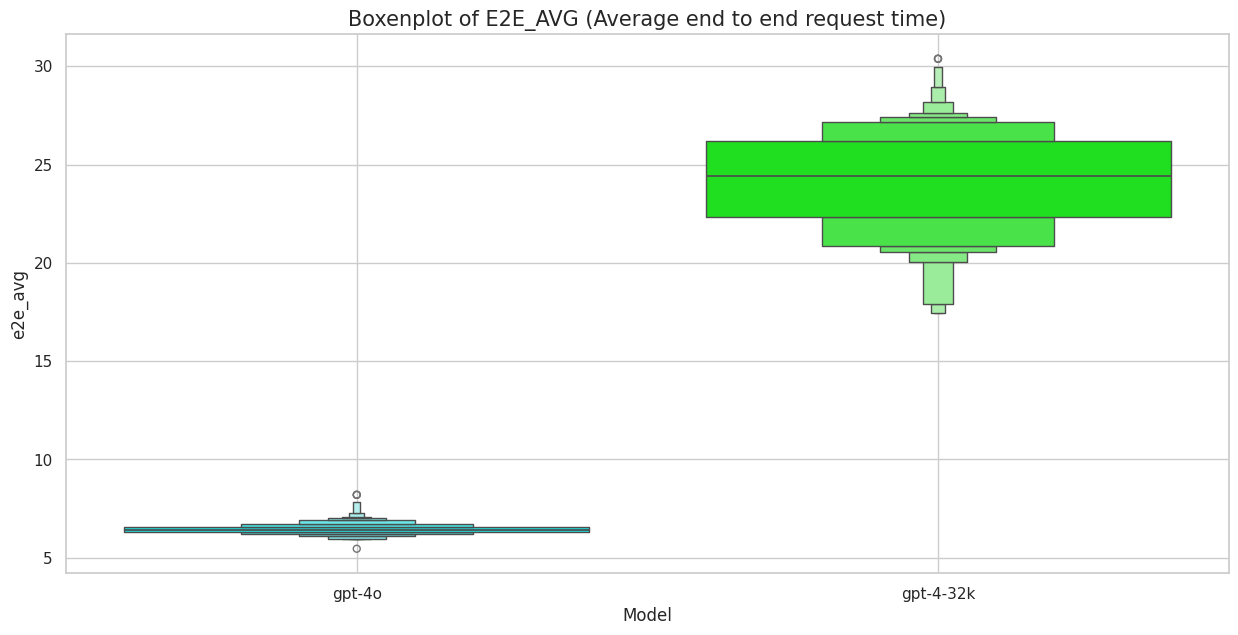

10


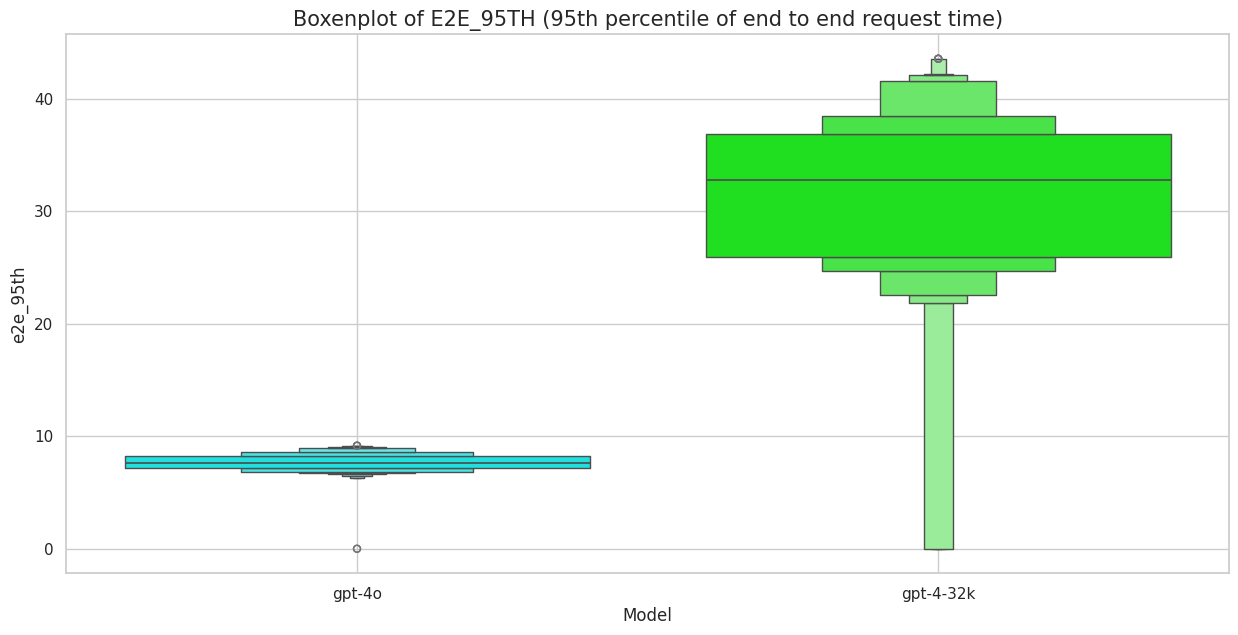

11


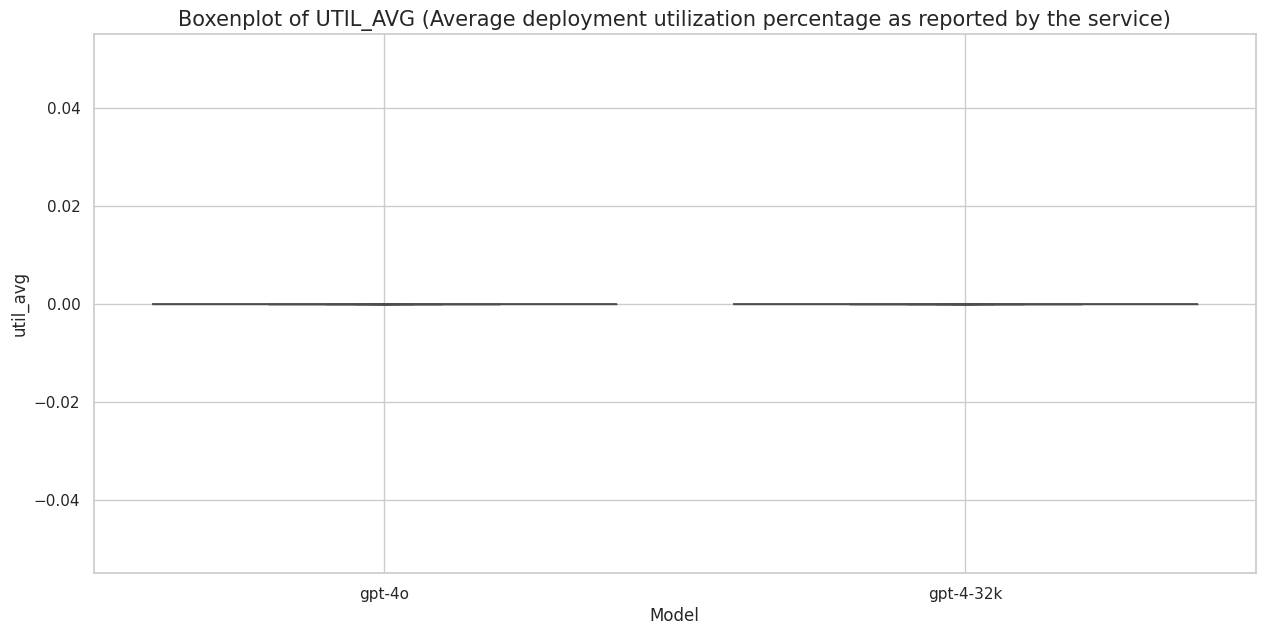

12


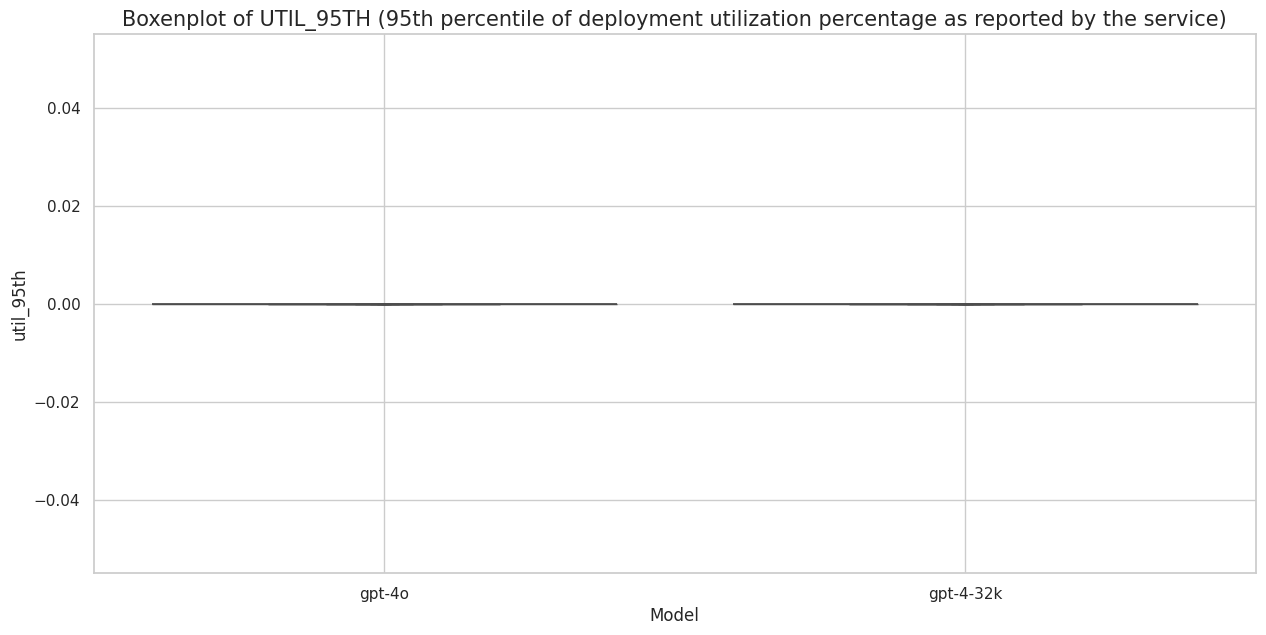

In [24]:
sns.set(style="whitegrid")
custom_palette = {'gpt-4o': color1, 'gpt-4-32k': color2}

idx = 1
for col in cols_to_plot:
    print(idx)
    plt.figure(figsize=(15, 7))
    sns.boxenplot(data=df, x='model', y=col, linewidth=1, hue='model', palette=custom_palette)
    plt.title(f'Boxenplot of {col.upper()} ({metrics_labels[col]})', size=15)
    plt.xlabel('Model')
    plt.ylabel(col)
    plt.grid(True)
    plt.savefig(os.path.join(REPORT_DIR, f'boxenplot_{col}_{dt}.png'))
    plt.show()
    idx += 1

## 4. Export to Excel

In [25]:
excel_doc = os.path.join(REPORT_DIR, f"benchmarks_{dt}.xlsx")

df.to_excel(excel_doc)

In [26]:
excel_link = FileLink(path=excel_doc)
excel_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/report/benchmarks_08Jul2024_142225.xlsx

In [27]:
!ls $excel_doc -l

-rwxrwxrwx 1 root root 143099 Jul  8 12:22 report/benchmarks_08Jul2024_142225.xlsx


## 5. Export to Word

In [28]:
word_file =  os.path.join(REPORT_DIR, f"benchmarks_{dt}.docx")

add_images_to_word(REPORT_DIR, word_file)

Done. Document saved as report/benchmarks_08Jul2024_142225.docx


In [29]:
doc_link = FileLink(path=word_file)
doc_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/report/benchmarks_08Jul2024_142225.docx

In [30]:
!ls $word_file -l

-rwxrwxrwx 1 root root 6941449 Jul  8 12:22 report/benchmarks_08Jul2024_142225.docx
